In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

ipdl_dir = os.path.join(project_dir, 'modules/SVDD')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

import numpy as np
import torch
import config
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from scipy.io import loadmat

dataset_path = os.path.join(config.DERMA_DATASET_DIR, 'train/')
subjects = os.listdir(dataset_path)[::12]

subject_data = []
for i in subjects:
    mat = loadmat(os.path.join(dataset_path, i))
    subject_data.append(mat['preProcessedImage'].astype(np.float64)[np.newaxis,:])

subject_data = np.nan_to_num(np.concatenate(subject_data))

In [ ]:
import scipy as sp
import scipy.linalg as splin

#############################################
# Internal functions
#############################################

def estimate_snr(Y,r_m,x):

  [L, N] = Y.shape           # L number of bands (channels), N number of pixels
  [p, N] = x.shape           # p number of endmembers (reduced dimension)
  
  P_y     = np.sum(Y**2)/float(N)
  P_x     = np.sum(x**2)/float(N) + np.sum(r_m**2)
  return 10*np.log10( (P_x - p/L*P_y)/(P_y - P_x) )


def vca(Y,R,verbose = True,snr_input = 0):
# Vertex Component Analysis
#
# Ae, indice, Yp = vca(Y,R,verbose = True,snr_input = 0)
#
# ------- Input variables -------------
#  Y - matrix with dimensions L(channels) x N(pixels)
#      each pixel is a linear mixture of R endmembers
#      signatures Y = M x s, where s = gamma x alfa
#      gamma is a illumination perturbation factor and
#      alfa are the abundance fractions of each endmember.
#  R - positive integer number of endmembers in the scene
#
# ------- Output variables -----------
# Ae     - estimated mixing matrix (endmembers signatures)
# indice - pixels that were chosen to be the most pure
# Yp     - Data matrix Y projected.   
#
# ------- Optional parameters---------
# snr_input - (float) signal to noise ratio (dB)
# v         - [True | False]
# ------------------------------------
#
# Author: Adrien Lagrange (adrien.lagrange@enseeiht.fr)
# This code is a translation of a matlab code provided by 
# Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
# available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
# Translation of last version at 22-February-2018 (Matlab version 2.1 (7-May-2004))
#
# more details on:
# Jose M. P. Nascimento and Jose M. B. Dias 
# "Vertex Component Analysis: A Fast Algorithm to Unmix Hyperspectral Data"
# submited to IEEE Trans. Geosci. Remote Sensing, vol. .., no. .., pp. .-., 2004
# 
# 

  #############################################
  # Initializations
  #############################################
  if len(Y.shape)!=2:
    sys.exit('Input data must be of size L (number of bands i.e. channels) by N (number of pixels)')

  [L, N]=Y.shape   # L number of bands (channels), N number of pixels
       
  R = int(R)
  if (R<0 or R>L):  
    sys.exit('ENDMEMBER parameter must be integer between 1 and L')
        
  #############################################
  # SNR Estimates
  #############################################

  if snr_input==0:
    y_m = np.mean(Y,axis=1,keepdims=True)
    Y_o = Y - y_m           # data with zero-mean
    Ud  = splin.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:R]  # computes the R-projection matrix 
    x_p = np.dot(Ud.T, Y_o)                 # project the zero-mean data onto p-subspace

    SNR = estimate_snr(Y,y_m,x_p)

  else:
    SNR = snr_input
    
  if verbose:
    print("input SNR = {}[dB]\n".format(SNR))

  SNR_th = 15 + 10*np.log10(R)
         
  #############################################
  # Choosing Projective Projection or 
  #          projection to R-1 subspace
  #############################################

  if SNR < SNR_th:
    if verbose:
      print("... Select proj. to R-1")
                
      d = R-1
      if snr_input==0: # it means that the projection is already computed
        Ud = Ud[:,:d]
      else:
        y_m = np.mean(Y,axis=1,keepdims=True)
        Y_o = Y - y_m  # data with zero-mean 
         
        Ud  = splin.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:d]  # computes the p-projection matrix 
        x_p =  np.dot(Ud.T,Y_o)                 # project thezeros mean data onto p-subspace
                
      Yp =  np.dot(Ud,x_p[:d,:]) + y_m      # again in dimension L
                
      x = x_p[:d,:] #  x_p =  Ud.T * Y_o is on a R-dim subspace
      c = np.amax(np.sum(x**2,axis=0))**0.5
      y = np.vstack(( x, c*np.ones((1,N)) ))
  else:
    if verbose:
      print("... Select the projective proj.")
             
    d = R
    Ud  = splin.svd(np.dot(Y,Y.T)/float(N))[0][:,:d] # computes the p-projection matrix 
                
    x_p = np.dot(Ud.T,Y)
    Yp =  np.dot(Ud,x_p[:d,:])      # again in dimension L (note that x_p has no null mean)
                
    x =  np.dot(Ud.T,Y)
    u = np.mean(x,axis=1,keepdims=True)        #equivalent to  u = Ud.T * r_m
    y =  x / (np.dot(u.T,x) + 1e-16)

  #############################################
  # VCA algorithm
  #############################################

  indice = np.zeros((R),dtype=int)
  A = np.zeros((R,R))
  A[-1,0] = 1

  for i in range(R):
    w = np.random.rand(R,1);   
    f = w - np.dot(A,np.dot(splin.pinv(A),w))
    f = f / splin.norm(f)
      
    v = np.dot(f.T,y)

    indice[i] = np.argmax(np.absolute(v))
    A[:,i] = y[:,indice[i]]        # same as x(:,indice(i))

  Ae = Yp[:,indice]

  return Ae,indice,Yp

In [ ]:
data = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], subject_data.shape[3])
data = data.T
Ae, indice, Yp = vca(data, 4, True, 0)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(Ae)
plt.show()

In [ ]:
indice

In [ ]:
plt.plot(data[:,indice])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import scipy.linalg as splin

class VCA(TransformerMixin, BaseEstimator):
    def __init__(self, n_endmembers:int, snr_input=0):
        super(VCA, self).__init__()
        self.n_endmembers = n_endmembers
        self.snr_input = snr_input

    def fit(self, X, y=None):
        '''
            Parameters
            ----------
                X : array, shape (n_samples, n_features)
                    Matrix with dimensions N (number of pixels) x L (number of  channels). Each pixel is a
                    linear mixture of R endmembers signatures Y = M x s, where s = gamma x alfa.
                    Gamma is a illumination perturbation factor and alfa are the abundance
                    fractions of each endmember

                y : any, default=None
                    Ignored. This parameter exists only for compatibility with
                    sklearn.pipeline.Pipeline.

            Returns
            -------
            self : object
                Returns the instance itself.
        '''
        X_ = X.T
        L, N = X_.shape   # L number of bands (channels), N number of pixels
        R = self.n_endmembers

        if (self.n_endmembers<0 or self.n_endmembers>L):
            raise ValueError('Number of endmemembers parameter must be integer between 1 and L')

        if self.snr_input == 0:
            y_m = np.mean(X_,axis=1,keepdims=True)
            Y_o = X_ - y_m           # data with zero-mean
            Ud  = splin.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:R]  # computes the R-projection matrix 
            x_p = np.dot(Ud.T, Y_o)                 # project the zero-mean data onto p-subspace

            SNR = self._estimate_snr(X_,y_m,x_p)
        else:
            SNR = self.snr_input

        SNR_th = 15 + 10*np.log10(R)

        if SNR < SNR_th:
            # ... Select proj. to R-1
            d = R-1
            if self.snr_input==0: # it means that the projection is already computed
                Ud = Ud[:,:d]
            else:
                y_m = np.mean(X_,axis=1,keepdims=True)
                Y_o = X_ - y_m  # data with zero-mean 
                
                Ud  = splin.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:d]  # computes the p-projection matrix 
                x_p =  np.dot(Ud.T,Y_o)                 # project the zeros-mean data onto p-subspace
                        
            Yp =  np.dot(Ud,x_p[:d,:]) + y_m      # again in dimension L
                        
            x = x_p[:d,:] #  x_p =  Ud.T * Y_o is on a R-dim subspace
            c = np.amax(np.sum(x**2,axis=0))**0.5
            y = np.vstack(( x, c*np.ones((1,N)) ))

        else: 
            # ... Select the projective proj.
                    
            d = R
            Ud  = splin.svd(np.dot(X_,X_.T)/float(N))[0][:,:d] # computes the p-projection matrix 
                        
            x_p = np.dot(Ud.T,X_)
            Yp =  np.dot(Ud,x_p[:d,:])      # again in dimension L (note that x_p has no null mean)
                        
            x =  np.dot(Ud.T,X_)
            u = np.mean(x,axis=1,keepdims=True)        #equivalent to  u = Ud.T * r_m
            y =  x / (np.dot(u.T,x) + 1e-16)

        #############################################
        # VCA algorithm
        #############################################

        indice = np.zeros((R),dtype=int)
        A = np.zeros((R,R))
        A[-1,0] = 1

        for i in range(R):
            w = np.random.rand(R,1);   
            f = w - np.dot(A,np.dot(splin.pinv(A),w))
            f = f / splin.norm(f)
            
            v = np.dot(f.T,y)

            indice[i] = np.argmax(np.absolute(v))
            A[:,i] = y[:,indice[i]]        # same as x(:,indice(i))

        Ae = Yp[:,indice]

        self.Ae_ = Ae
        self.idx_ = indice
        self.Xp_ = Yp
        
        return self

    def transform(self, X, y=None, **kwargs):
        check_is_fitted(self)
        return self.Xp_[:,self.idx_]

    def _estimate_snr(self, X, X_mean_0, reduced_x) -> float:
        L, N = X.shape          # L number of bands (channels), N number of pixels
        p, N = reduced_x.shape  # p number of endmembers (reduced dimension)
        
        P_y     = np.sum(X**2)/float(N)
        P_x     = np.sum(reduced_x**2)/float(N) + np.sum(X_mean_0**2)
        return 10*np.log10( (P_x - p/L*P_y)/(P_y - P_x) )


In [ ]:
eea = VCA(4)
data = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], subject_data.shape[3])
endmembers = eea.fit_transform(data)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(endmembers)
plt.show()

In [ ]:
y_m = np.mean(data,axis=1,keepdims=True)
y_m.shape

In [ ]:
Y_o = data - y_m
Y_o.shape

In [ ]:
R=3
N=Y_o.shape[1]
Ud  = splin.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:R]

In [ ]:
# Ud = np.linalg.svd(np.dot(Y_o,Y_o.T)/N)[0][:,:R]

In [ ]:
x_p = np.dot(Ud.T, Y_o)

SNR = estimate_snr(data,y_m,x_p)
SNR

In [ ]:
from sklearn.decomposition import KernelPCA

data = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], subject_data.shape[3])

kpca = KernelPCA(n_components=6, kernel="rbf", gamma=0.1, fit_inverse_transform=True)
data_kpca = kpca.fit_transform(data)

In [ ]:
data_kpca.shape

In [ ]:
from SVDD import BaseSVDD
data = subject_data.reshape(subject_data.shape[0]*subject_data.shape[1]*subject_data.shape[2], subject_data.shape[3])

eea = BaseSVDD(C=0.9, gamma=0.3, kernel='rbf', display='on')
eea.fit(data[:3000])
# endmembers = eea.fit_transform(data)

In [14]:
from HySpecLab.dataset import DermaDataset

train_dir = ['train', 'validation']
dataset_dir = list(map(lambda x: os.path.join(config.DERMA_DATASET_DIR, x), train_dir))

dataset = DermaDataset(dataset_dir)

In [87]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Randomly selecting a subset of data for the targeted classes:
# rus = RandomUnderSampler(random_state=123)
# x, y = rus.fit_resample(x, y)

# # Let positive samples be the samples belonging to the targeted class to be under-sampled. 
# # Negative sample refers to the samples from the minority class.
# # Select the positive samples for which the average distance to the N closest samples of the negative 
# # class is the smallest
sampling_strategy = {0: 500, 1: 500}
nm = NearMiss(sampling_strategy=sampling_strategy, version=3)
x, y = dataset.get(dataframe=False)
X_resampled, y_resampled = nm.fit_resample(x, y)

In [88]:
import scipy.linalg as splin

def _proj_subspace(X, d):
    '''
        Project data onto a subspace d. This method uses SVD. SVD and PCA are
        also equal in the case of zero-mean data.

        Params
        -----
        X : array, shape (n_features, n_samples)
            Data that will be projected in the subspace d.

        d : int
            Space where the zero-mean data will be projected.

        Return
        ------
            (Data projected onto subspace d, Tranform matrix which project data onto d-space).
    '''
    _, N = X.shape
    Ud  = splin.svd(np.dot(X,X.T)/float(N))[0][:,:d]   # computes the d-projection matrix 
    return (np.dot(Ud.T, X), Ud)

In [149]:
n_endmembers = 4

data_p, Ud = _proj_subspace(X_resampled.T, n_endmembers)

In [150]:
Xp = np.dot(Ud,data_p[:n_endmembers,:]) # again in dimension L (note that X_p has no zero mean)
print(Xp.shape)

(116, 1000)


In [151]:
from SVDD import BaseSVDD

eea = BaseSVDD(C=0.9, gamma=.3, kernel='rbf', display='off')
eea.fit(data_p.T)

BaseSVDD(C=[0.9, 1], display='off', gamma=0.3)

In [152]:
print(eea.support_vector_indices)
print(eea.support_vector_alpha)
choosen = np.argsort(eea.support_vector_alpha, axis=0)[-4::].flatten()
print(eea.support_vector_alpha[choosen])
print(eea.support_vector_indices[choosen])

eea.support_vector_alpha = eea.support_vector_alpha[choosen]
eea.support_vector_indices = eea.support_vector_indices[choosen]
# print(sv_idx)

[ 80  82 117 159 166 363 483 500 502 527 533 564 596 625 711 782 830 867
 882 894 963]
[[4.58743529e-03]
 [4.57880221e-03]
 [6.80506561e-02]
 [8.53747933e-02]
 [5.16882942e-03]
 [2.19287296e-02]
 [3.91501558e-02]
 [1.02180261e-01]
 [1.52380124e-02]
 [5.19776006e-02]
 [3.78105489e-02]
 [7.56588002e-02]
 [1.44254549e-01]
 [5.35101923e-03]
 [4.37019328e-02]
 [1.43878393e-06]
 [3.82056944e-02]
 [6.50163696e-02]
 [6.11313163e-02]
 [7.73702642e-02]
 [5.32622852e-02]]
[[0.07737026]
 [0.08537479]
 [0.10218026]
 [0.14425455]]
[894 159 500 596]


Calculating the grid scores (0050*0050)...

Calculation of the grid scores is completed. Time cost 0.1503 seconds



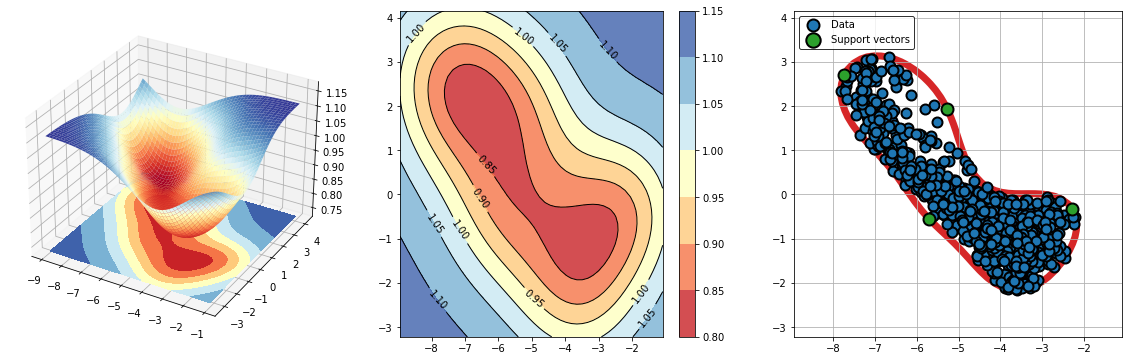

In [140]:
eea.plot_boundary(data_p.T)

In [64]:
eea.support_vector_indices

array([  25,  117,  166, 1529, 1530, 1531, 1596, 1625, 1782, 1867, 1928,
       2597, 2961])

In [142]:
data_p.T

(2, 1000)

In [153]:
result = Xp.T[eea.support_vector_indices]

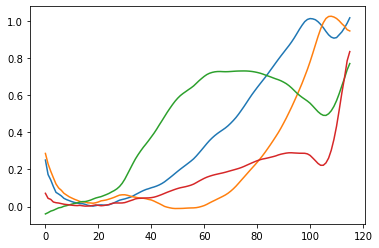

In [154]:
from matplotlib import pyplot as plt
plt.plot(result.T)

In [65]:
eea.support_vectors

array([[-2.13428743e+00, -7.22792448e-01, -5.76065292e-01,
        -4.55680483e-01,  2.41268839e-01, -8.37058657e-02,
        -1.40694822e-01,  1.88430027e-01, -2.34578512e-01,
        -6.96431633e-03,  6.81087436e-02,  1.58284420e-02,
         2.65910392e-02, -9.58247626e-03, -2.86074823e-03,
        -4.95877276e-02,  6.01401121e-02,  1.60873904e-02,
        -4.00646571e-02, -1.70472426e-02,  8.84701762e-03,
        -3.36639107e-02,  1.54020415e-02, -3.46180772e-02,
        -1.93068370e-02],
       [-6.81021616e+00,  2.24841296e+00, -1.05496800e+00,
        -1.77798219e-01,  1.50137561e-01,  3.99815513e-01,
        -1.27772006e-01, -9.56600920e-02,  7.30237309e-02,
        -1.07639079e-01,  8.24320004e-02,  8.23139555e-02,
         7.87925553e-04,  1.37737528e-02,  1.34434232e-03,
         4.52587542e-02,  2.03091822e-02, -4.04255590e-02,
        -1.88924298e-03,  2.41783452e-02,  2.64083668e-02,
         1.40674097e-02,  9.95004029e-03, -1.41296663e-02,
        -2.69386547e-02],
    

In [66]:
eea.support_vector_alpha

array([[0.0700788 ],
       [0.00376851],
       [0.18746585],
       [0.06869379],
       [0.08334096],
       [0.02797451],
       [0.1247505 ],
       [0.02570449],
       [0.00146863],
       [0.17631165],
       [0.02720127],
       [0.02922946],
       [0.17401116]])

In [33]:
eea.y @ eea.y.T

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])